**SCRAPING DATA**

In [ ]:
!pip install google-play-scraper pandas tqdm
from google_play_scraper import reviews, Sort
import pandas as pd
from tqdm import tqdm
def scrape_reviews(app_id, app_name, total_reviews=2000):
    all_reviews = []
    count = 0
    with tqdm(total=total_reviews, desc=f"Scraping {app_name}") as pbar:
        while count < total_reviews:
            result, _ = reviews(
                app_id,
                lang='id',
                country='id',
                sort=Sort.NEWEST,
                count=2000
            )
            for r in result:
                if count >= total_reviews:
                    break
                all_reviews.append({
                    'review': r['content'],
                    'score': r['score'],
                    'aplikasi': app_name
                })
                count += 1
                pbar.update(1)
    return pd.DataFrame(all_reviews)
shopee_df = scrape_reviews('com.shopee.id', 'Shopee', 2500)
tokopedia_df = scrape_reviews('com.tokopedia.tkpd', 'Tokopedia', 2500)
lazada_df = scrape_reviews('com.lazada.android', 'Lazada', 2500)


In [ ]:
df = pd.concat([shopee_df, tokopedia_df, lazada_df], ignore_index=True)
df

In [ ]:
df.to_csv('ReviewMentah.csv', index=False, encoding='utf-8')

**LOAD DATA**

In [ ]:
import pandas as pd
df =pd.read_csv('/content/drive/MyDrive/ReviewMentah.csv')
df.head()

review  score aplikasi
0  shopee sangat bagus aku selalu pakek shopee      5   Shopee
1                      sangat bagus layanannya      5   Shopee
2                                 ⚠️👍🌟🌟🌟🌟🌟❗️🙏.      5   Shopee
3                                        buruk      3   Shopee
4                                     mantulll      5   Shopee

**PREPROCESSING**

In [ ]:
df.isnull().sum()

review      0
score       0
aplikasi    0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(2357)

In [ ]:
#menampilkan duplikat
df[df.duplicated()]

review  score aplikasi
62                                               mantap      5   Shopee
93                                                bagus      5   Shopee
117                                                  ok      5   Shopee
130                                              mantap      5   Shopee
152                                              mantap      5   Shopee
...                                                 ...    ...      ...
7495                                            top bgt      5   Lazada
7496                                               kren      5   Lazada
7497  cara atasi limit lazada paylater yg di non akt...      3   Lazada
7498                       sangat cocok untuk kebutuhan      5   Lazada
7499  kini lazada masalah pengiriman nya,udh tidak l...      5   Lazada

[2357 rows x 3 columns]

In [ ]:
df = df.drop_duplicates()

In [ ]:
#cek ulang duplikat
df.duplicated().sum()

np.int64(0)

In [ ]:
#case folding
df['review'] = df['review'].str.lower()

In [ ]:
#cleaning
!pip install emoji
import emoji
import re
import string
def clean_text(text):
    text = str(text)
    # 1. HAPUS EMOJI
    text = emoji.replace_emoji(text, replace='')
    # 2. HAPUS NON-ASCII
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # 3. HAPUS ANGKA
    text = re.sub(r'\d+', ' ', text)
    # 4. HAPUS TANDA BACA / PUNCTUATION
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 5. HAPUS SPASI BERLEBIH
    text = re.sub(r'\s+', ' ', text).strip()
    return text


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 9.6 MB/s eta 0:00:00


In [ ]:
#menghapus review kosong
df = df[df['review'].str.strip() != '']
df.reset_index(drop=True, inplace=True)

In [ ]:
#normalisasi huruf berulang
def remove_double_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
df['review'] = df['review'].apply(remove_double_char)

In [ ]:
#normalisasi kata gaul dan typo
normalisasi_dict = {
    'gk': 'tidak', 'tampa': 'tanpa',
    'ga': 'tidak', 'tak': 'tidak',
    'nggak': 'tidak','prnh': 'pernah',
    'tdk': 'tidak', 'dlm': 'dalam',
    'bgt': 'banget', 'dgn': 'dengan',
    'cs': 'customer service','tpi': 'tapi',
    'apk': 'aplikasi', 'jd': 'jadi',
    'udh': 'sudah', 'bagu': 'bagus',
    'blm': 'belum', 'jela': 'jelas',
    'sy': 'saya', 'mengagu': 'mengganggu',
    'apan': 'apaan', 'muas': 'puas',
    'klau': 'kalau',
    'gak': 'tidak',
    'trs': 'terus',
    'kalo': 'kalau',
    'spy': 'supaya',
    'skrng': 'sekarang',
    'tbtb': 'tiba-tiba'
}
def normalize_text(text):
    words = text.split()
    normalized_words = [normalisasi_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

df['review'] = df['review'].apply(normalize_text)

In [ ]:
#tokenizing
df['tokens'] = df['review'].apply(lambda x: x.split())

In [ ]:
#stopword
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stopword_factory = StopWordRemoverFactory()
stopwords = set(stopword_factory.get_stop_words())
# stopword tambahan
domain_stopwords = {
    'aplikasi', 'jadi', 'kalau', 'sudah', 'sering', 'semua',
    'sama', 'buat', 'sini', 'padahal',
    'shope', 'shopee', 'dong',
    'lazada', 'kirim',
    'tokopedia', 'beli', 'pakai', 'belanja', 'barang'
}
all_stopwords = stopwords.union(domain_stopwords)
df['tokens'] = df['tokens'].apply(
    lambda x: [word for word in x if word not in all_stopwords])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
#stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()
df['tokens'] = df['tokens'].apply(
    lambda x: [stemmer.stem(word) for word in x]
)

In [ ]:
#hapus kata kurang dari 3
df['tokens'] = df['tokens'].apply(
    lambda x: [word for word in x if len(word) > 3]
)

In [ ]:
#gabungkan token menjadi kalimat
df['clean_review'] = df['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
# hapus data yang tokennya kosong
df = df[df['clean_review'].str.strip() != '']
# reset index
df.reset_index(drop=True, inplace=True)


In [ ]:
df.head()

review  score aplikasi  \
0  shope sangat bagus aku selalu pakek shope      5   Shopee   
1                     sangat bagus layananya      5   Shopee   
2                                      buruk      3   Shopee   
3                                     mantul      5   Shopee   
4               ok keren banget mantab bagus      5   Shopee   

                           tokens               clean_review  
0  [sangat, bagus, selalu, pakek]  sangat bagus selalu pakek  
1      [sangat, bagus, layananya]     sangat bagus layananya  
2                         [buruk]                      buruk  
3                        [mantul]                     mantul  
4  [keren, banget, mantab, bagus]  keren banget mantab bagus

In [ ]:
df.to_csv('ReviewBersih.csv', index=False, encoding='utf-8')

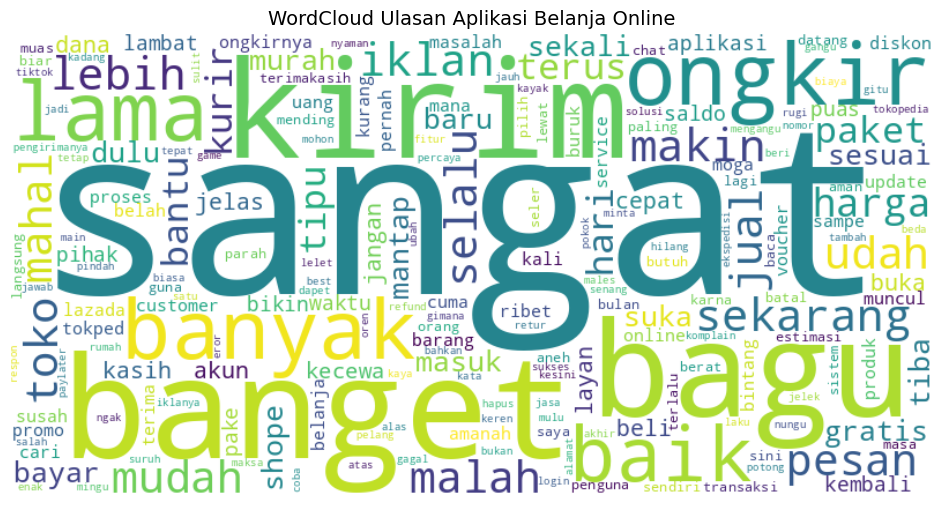

In [ ]:
!pip install wordcloud matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_text = ' '.join(df['clean_review'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations=False
).generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Aplikasi Belanja Online', fontsize=14)
plt.show()



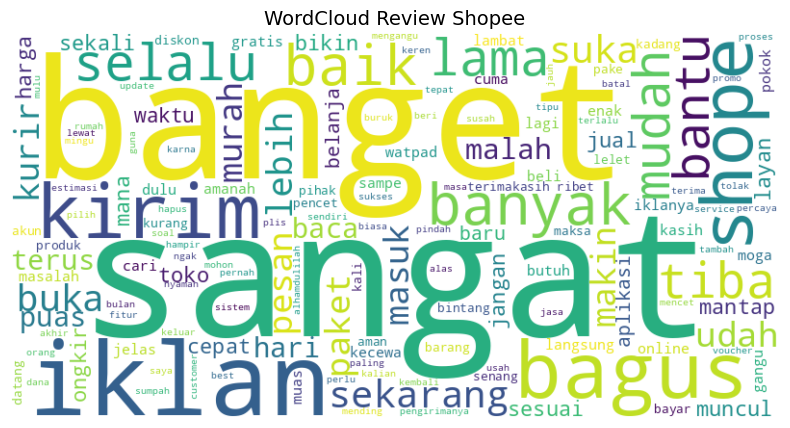

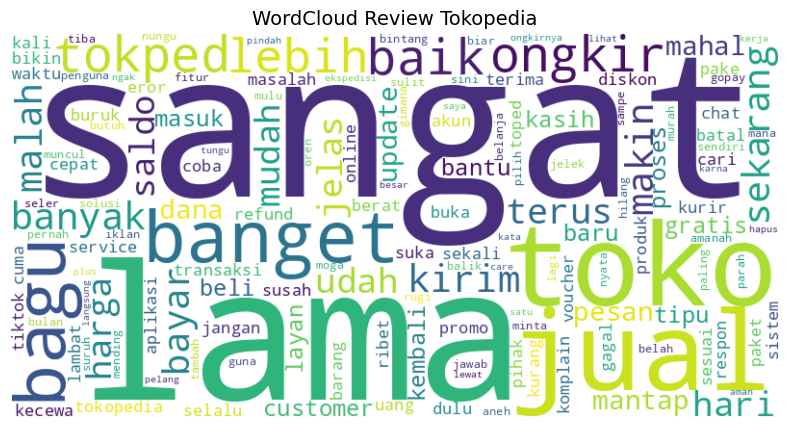

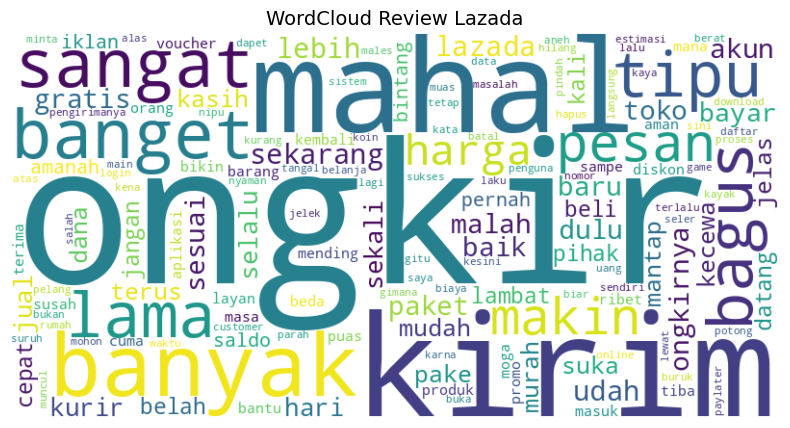

In [ ]:
apps = df['aplikasi'].unique()

for app in apps:
    text_app = ' '.join(df[df['aplikasi'] == app]['clean_review'])

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=150,
        collocations=False
    ).generate(text_app)

    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud Review {app}', fontsize=14)
    plt.show()


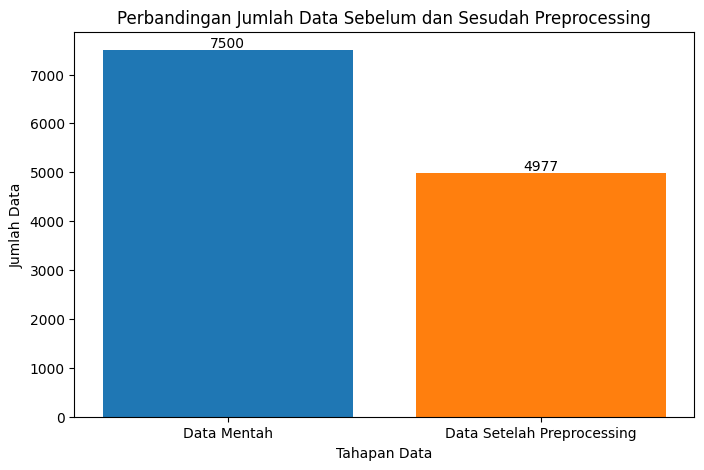

In [ ]:
#perbandingan jumlah data sebelum dan sesudah preprocessing
df_raw = pd.read_csv('/content/drive/MyDrive/ReviewMentah.csv')

jumlah_data_mentah = df_raw.shape[0]
jumlah_data_bersih = df.shape[0]

import matplotlib.pyplot as plt

labels = ['Data Mentah', 'Data Setelah Preprocessing']
values = [jumlah_data_mentah, jumlah_data_bersih]
colors = ['tab:blue', 'tab:orange']  # warna dibedakan

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color=colors)

plt.title('Perbandingan Jumlah Data Sebelum dan Sesudah Preprocessing')
plt.ylabel('Jumlah Data')
plt.xlabel('Tahapan Data')

# tampilkan angka di atas batang
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        str(height),
        ha='center',
        va='bottom'
    )

plt.show()



/tmp/ipython-input-2598433987.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] - width/2, mentah[i], str(int(mentah[i])), ha='center', va='bottom')
/tmp/ipython-input-2598433987.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] + width/2, bersih[i], str(int(bersih[i])), ha='center', va='bottom')


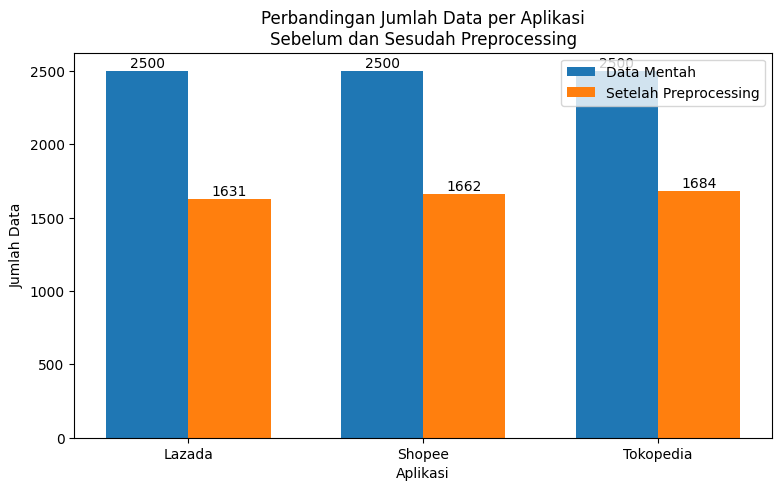

In [ ]:
#perbandingan data setelah dan sebelum preprocessing untuk setiap aplikasi
data_mentah = df_raw['aplikasi'].value_counts()
data_bersih = df['aplikasi'].value_counts()

import pandas as pd

df_perbandingan = pd.DataFrame({
    'Data Mentah': data_mentah,
    'Data Setelah Preprocessing': data_bersih
}).fillna(0)

import matplotlib.pyplot as plt
import numpy as np

labels = df_perbandingan.index
mentah = df_perbandingan['Data Mentah']
bersih = df_perbandingan['Data Setelah Preprocessing']

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, mentah, width, label='Data Mentah', color='tab:blue')
plt.bar(x + width/2, bersih, width, label='Setelah Preprocessing', color='tab:orange')

plt.xlabel('Aplikasi')
plt.ylabel('Jumlah Data')
plt.title('Perbandingan Jumlah Data per Aplikasi\nSebelum dan Sesudah Preprocessing')
plt.xticks(x, labels)
plt.legend()

# tampilkan angka
for i in range(len(labels)):
    plt.text(x[i] - width/2, mentah[i], str(int(mentah[i])), ha='center', va='bottom')
    plt.text(x[i] + width/2, bersih[i], str(int(bersih[i])), ha='center', va='bottom')

plt.show()


**PELABELAN**

In [ ]:
kata_positif = {
    'bagus', 'murah', 'cepat', 'mudah', 'mantap',
    'puas', 'baik', 'recommended',
    'suka', 'senang', 'aman', 'terpercaya'
}
kata_negatif = {
    'buruk', 'jelek', 'lama', 'mahal', 'kecewa',
    'ribet', 'susah', 'error', 'parah', 'tipu',
    'gagal', 'bohong', 'lemot', 'masalah', 'ganggu', 'iklan', 'kurang'
}
def label_sentimen(text):
    tokens = text.split()

    pos = sum(1 for t in tokens if t in kata_positif)
    neg = sum(1 for t in tokens if t in kata_negatif)

    if pos > neg:
        return 'Positif'
    elif neg > pos:
        return 'Negatif'
    else:
        return 'Netral'
df['sentimen'] = df['clean_review'].apply(label_sentimen)

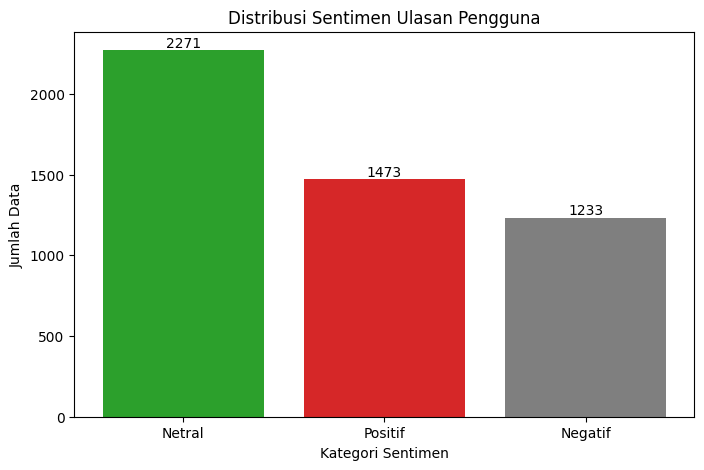

In [ ]:
#cek distribusi label
sentimen_count= df['sentimen'].value_counts()
sentimen_count
import matplotlib.pyplot as plt

labels = sentimen_count.index
values = sentimen_count.values
colors = ['tab:green', 'tab:red', 'tab:gray']

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color=colors)

plt.title('Distribusi Sentimen Ulasan Pengguna')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah Data')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        str(height),
        ha='center',
        va='bottom'
    )

plt.show()


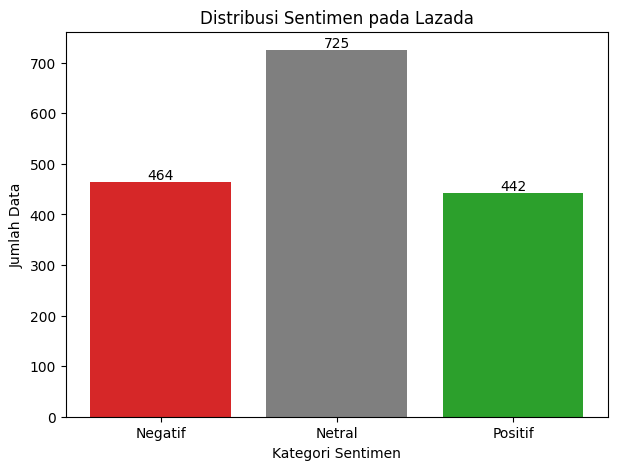

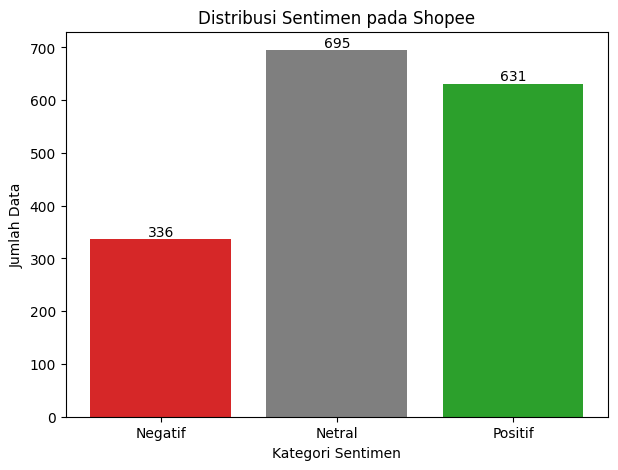

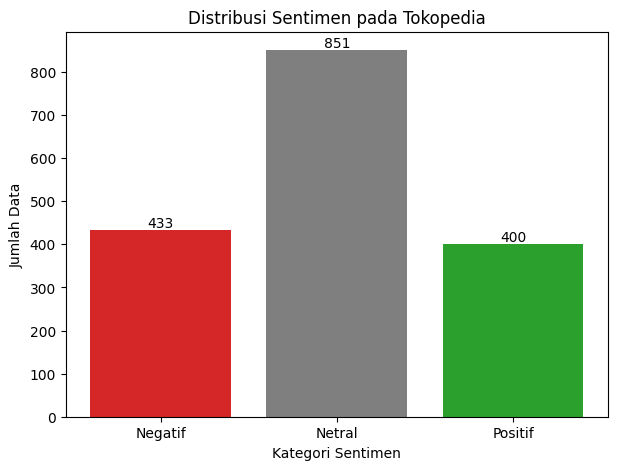

In [ ]:
#distribusi sentimen setiap aplikasi
sentimen_aplikasi = df.groupby(['aplikasi', 'sentimen']).size().unstack(fill_value=0)
import matplotlib.pyplot as plt

colors = {
    'Positif': 'tab:green',
    'Negatif': 'tab:red',
    'Netral': 'tab:gray'
}

for app in sentimen_aplikasi.index:
    plt.figure(figsize=(7,5))

    values = sentimen_aplikasi.loc[app]
    bars = plt.bar(values.index, values.values,
                   color=[colors[s] for s in values.index])

    plt.title(f'Distribusi Sentimen pada {app}')
    plt.xlabel('Kategori Sentimen')
    plt.ylabel('Jumlah Data')

    # angka di atas batang
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            str(height),
            ha='center',
            va='bottom'
        )

    plt.show()

In [ ]:
#cek validasi sentimen
df[['clean_review', 'sentimen']].sample(10)

clean_review sentimen
147                                        banyak promo   Netral
1987                      mana kata gratis ongkir terus   Netral
925                  sangat mudah guna cari butuh ingin  Positif
2408  kapok sini kembali dana refundnya lama jelas c...  Negatif
555                                sangat murah percaya  Positif
182                                          kirim lama  Negatif
4179                    kecewa fitur plus sangat nyaman  Negatif
3716                                               best   Netral
4271                                               scam   Netral
1136  kurang amanah banyak toko tipu toko gitu janga...  Negatif

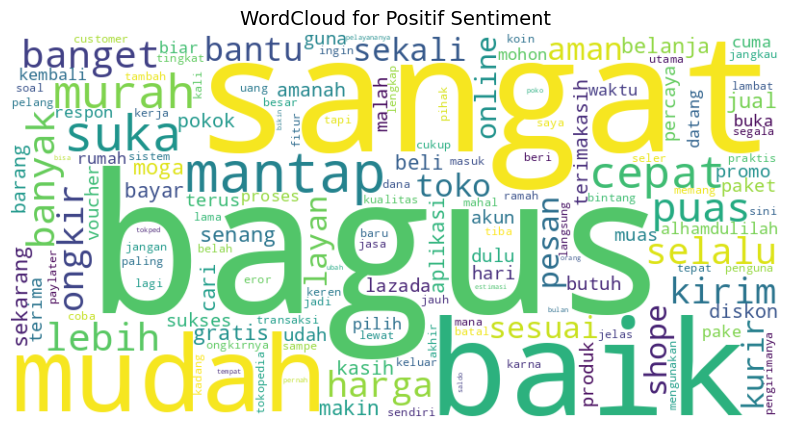

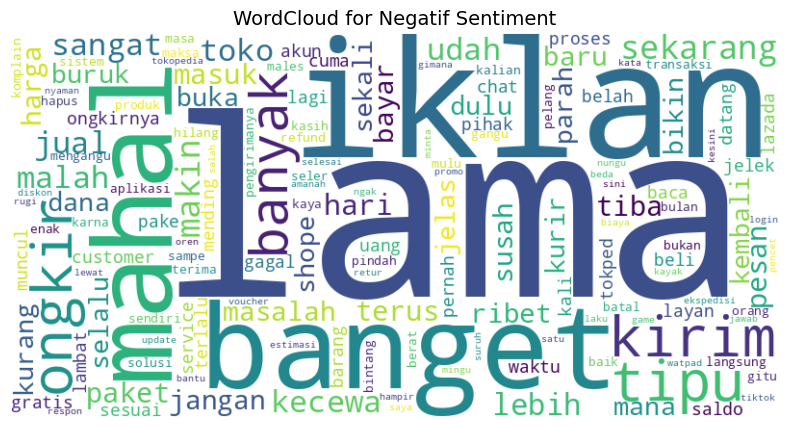

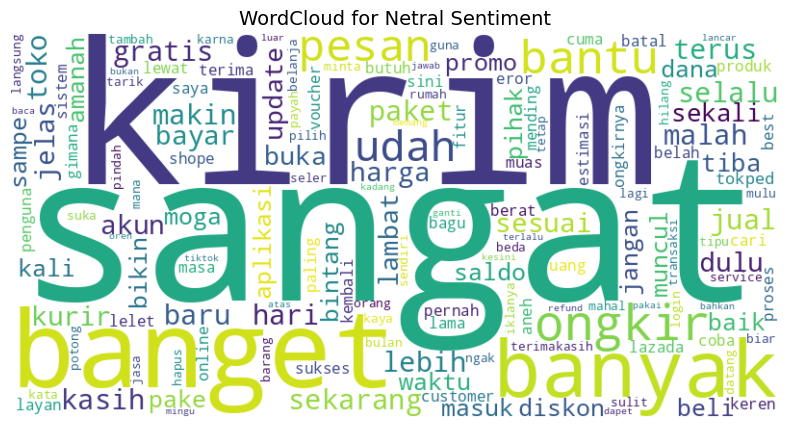

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get unique sentiments
sentiments = df['sentimen'].unique()

for sentiment in sentiments:
    # Filter reviews by sentiment
    text_sentiment = ' '.join(df[df['sentimen'] == sentiment]['clean_review'])

    # Generate WordCloud
    wc_sentiment = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=150,
        collocations=False
    ).generate(text_sentiment)

    # Plot WordCloud
    plt.figure(figsize=(12, 5))
    plt.imshow(wc_sentiment, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {sentiment} Sentiment', fontsize=14)
    plt.show()

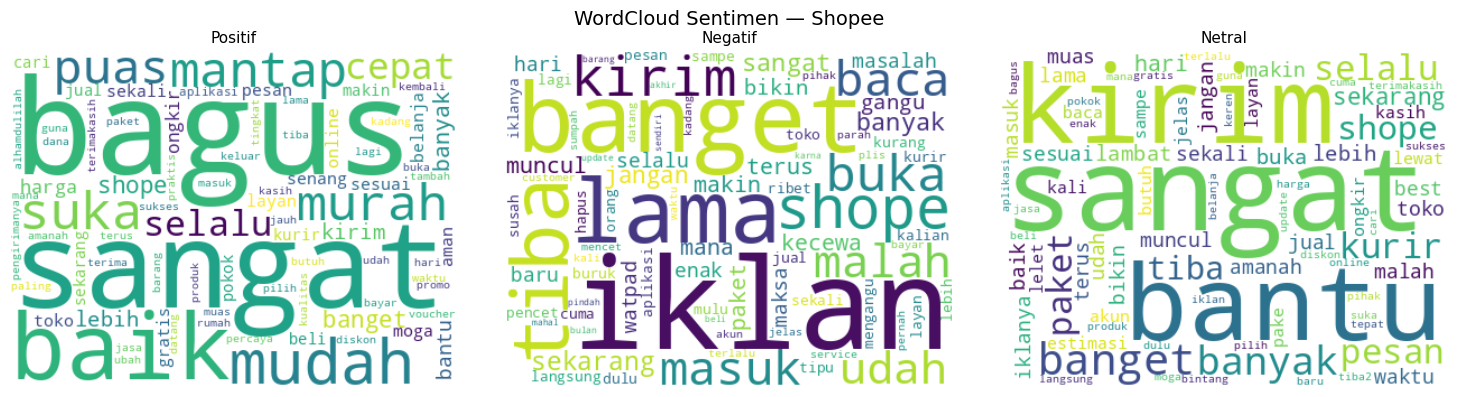

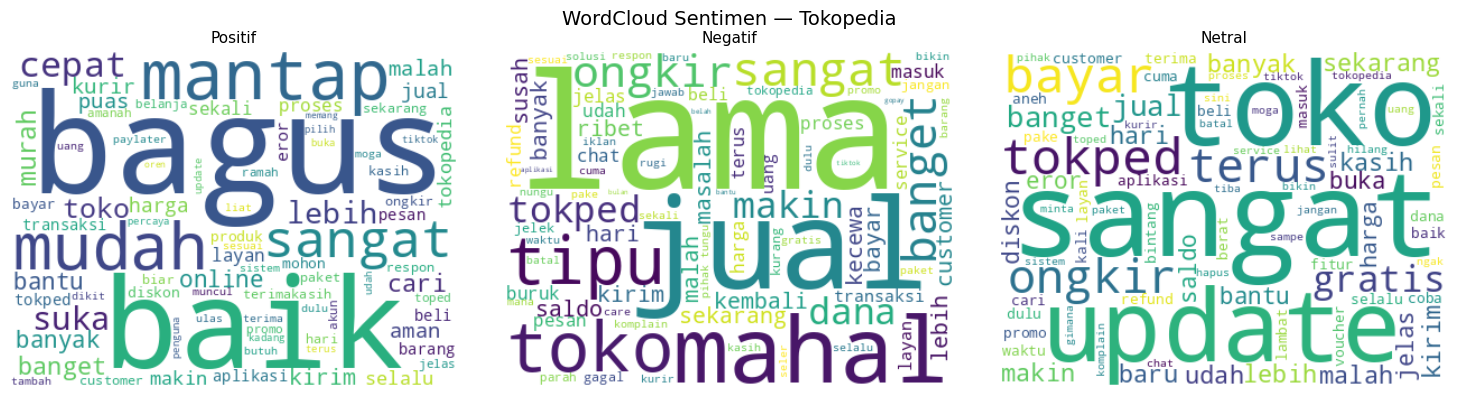

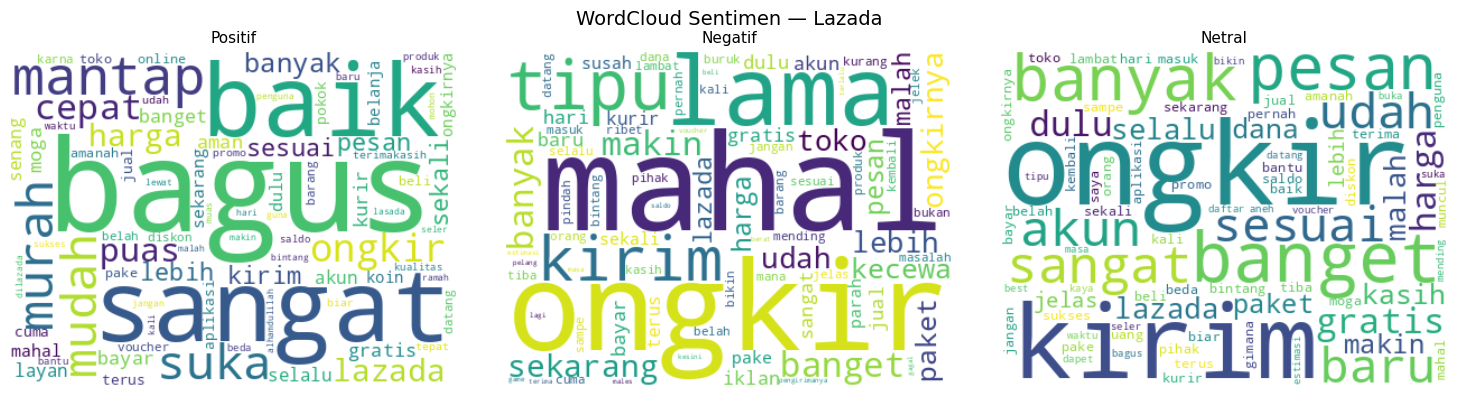

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

aplikasi_list = df['aplikasi'].unique()
sentimen_list = ['Positif', 'Negatif', 'Netral']

for app in aplikasi_list:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for ax, sent in zip(axes, sentimen_list):
        text_data = ' '.join(
            df[
                (df['aplikasi'] == app) &
                (df['sentimen'] == sent)
            ]['clean_review']
        )

        if text_data.strip() != '':
            wc = WordCloud(
                width=400,
                height=300,
                background_color='white',
                max_words=80,
                collocations=False
            ).generate(text_data)

            ax.imshow(wc, interpolation='bilinear')
            ax.axis('off')
            ax.set_title(sent, fontsize=11)
        else:
            ax.axis('off')
            ax.set_title(f'{sent}\n(Tidak ada data)', fontsize=10)

    fig.suptitle(f'WordCloud Sentimen — {app}', fontsize=14)
    plt.tight_layout()
    plt.show()


**N-GRAM**

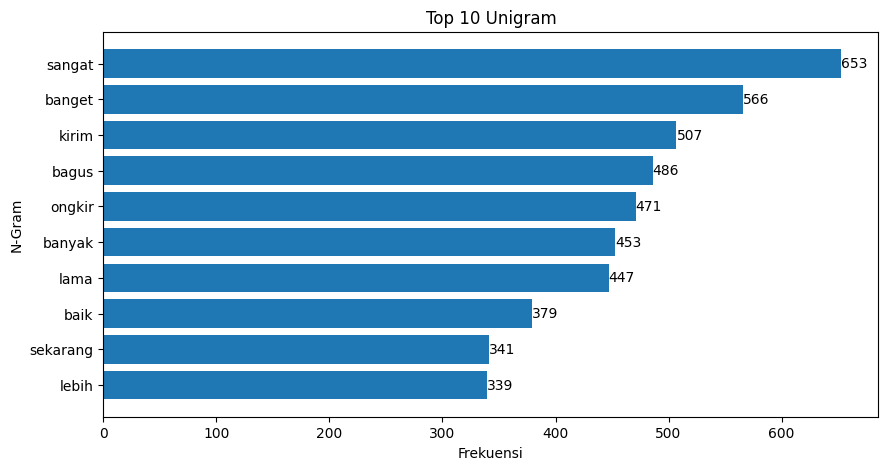

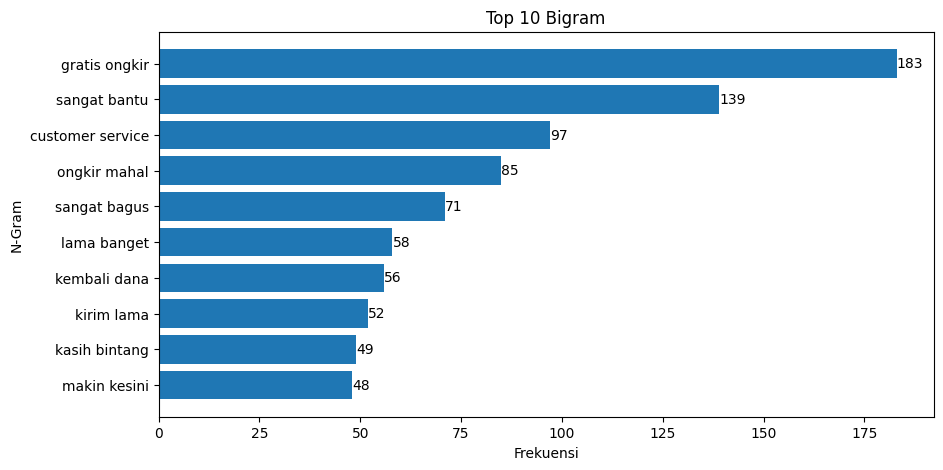

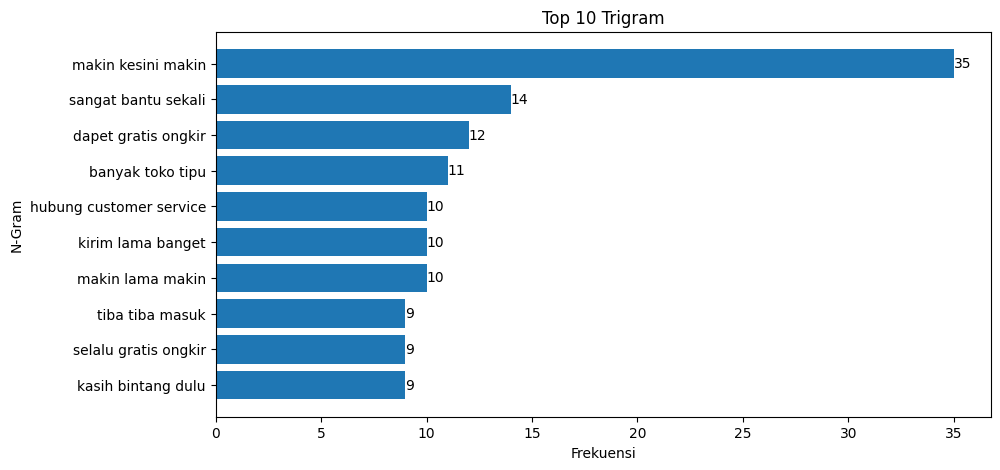

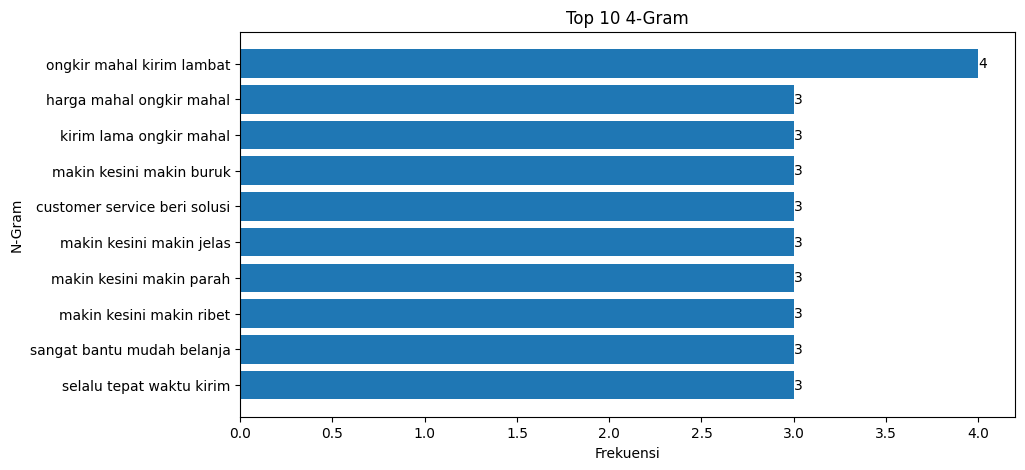

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
def ngram_bar_chart(
    df,
    ngram_range=(1,1),
    min_df=5,
    top_n=10,
    title=''
):
    vectorizer = CountVectorizer(
        ngram_range=ngram_range,
        min_df=min_df
    )

    X = vectorizer.fit_transform(df['clean_review'])

    ngram_freq = pd.DataFrame(
        X.sum(axis=0),
        columns=vectorizer.get_feature_names_out()
    ).T

    ngram_freq.columns = ['Frekuensi']
    ngram_freq = ngram_freq.sort_values(
        by='Frekuensi',
        ascending=False
    ).head(top_n)

    # BAR CHART
    plt.figure(figsize=(10,5))
    bars = plt.barh(
        ngram_freq.index,
        ngram_freq['Frekuensi']
    )

    plt.xlabel('Frekuensi')
    plt.ylabel('N-Gram')
    plt.title(title)
    plt.gca().invert_yaxis()

    # tampilkan angka frekuensi
    for bar in bars:
        plt.text(
            bar.get_width(),
            bar.get_y() + bar.get_height()/2,
            str(int(bar.get_width())),
            va='center'
        )

    plt.show()

    return ngram_freq
unigram = ngram_bar_chart(
    df,
    ngram_range=(1,1),
    min_df=10,
    top_n=10,
    title='Top 10 Unigram'
)

bigram = ngram_bar_chart(
    df,
    ngram_range=(2,2),
    min_df=7,
    top_n=10,
    title='Top 10 Bigram'
)
trigram = ngram_bar_chart(
    df,
    ngram_range=(3,3),
    min_df=5,
    top_n=10,
    title='Top 10 Trigram'
)
fourgram = ngram_bar_chart(
    df,
    ngram_range=(4,4),
    min_df=3,
    top_n=10,
    title='Top 10 4-Gram'
)


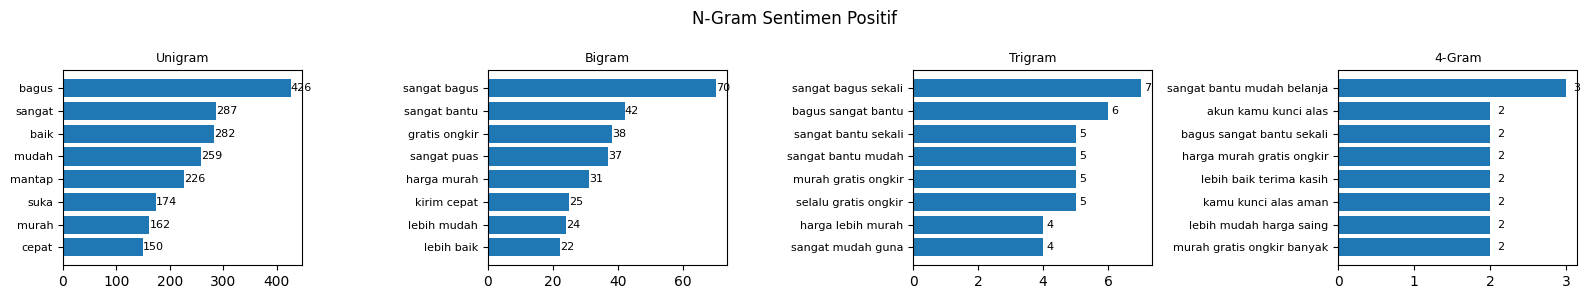

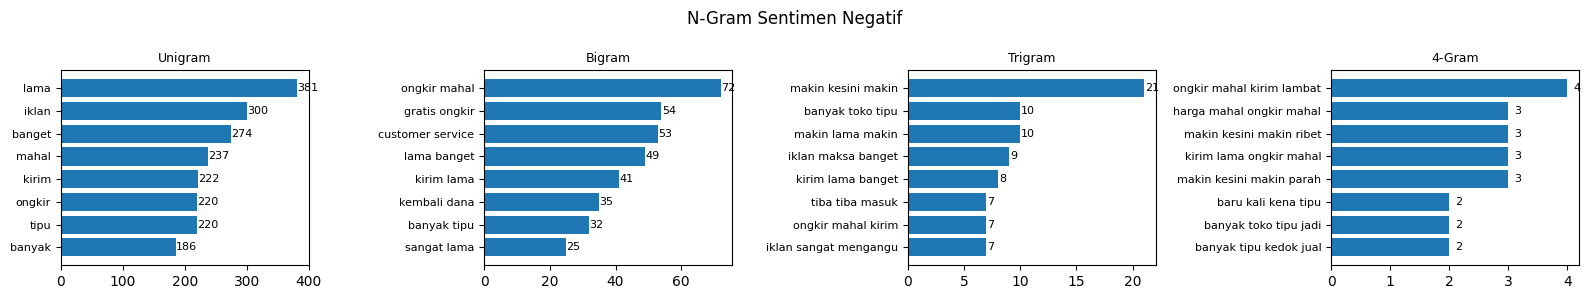

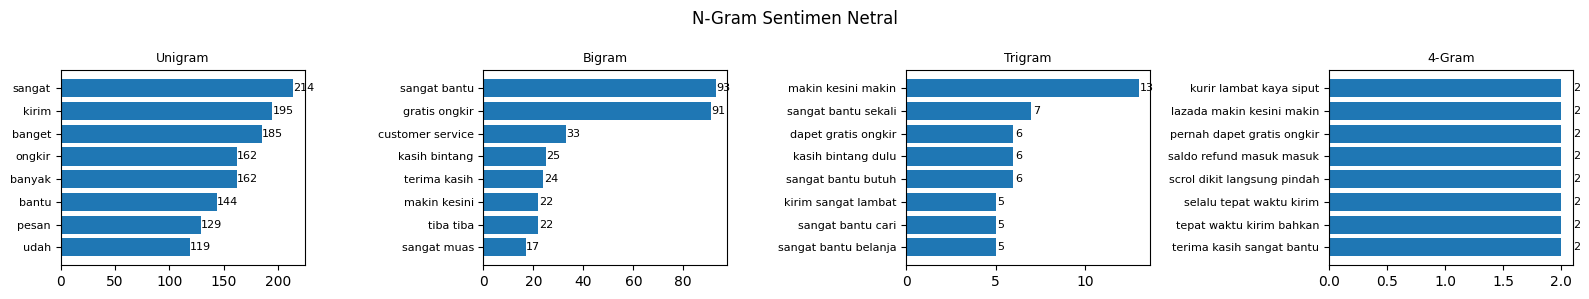

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

def plot_ngram_sentimen_subplot(df, sentimen, top_n=8):
    ngram_configs = {
        'Unigram': ((1,1), 5),
        'Bigram':  ((2,2), 3),
        'Trigram': ((3,3), 3),
        '4-Gram':  ((4,4), 2)
    }

    data = df[df['sentimen'] == sentimen]

    if len(data) == 0:
        return

    fig, axes = plt.subplots(1, 4, figsize=(16, 3))

    for ax, (nama, (ngram_range, min_df)) in zip(axes, ngram_configs.items()):
        try:
            vectorizer = CountVectorizer(
                ngram_range=ngram_range,
                min_df=min_df
            )

            X = vectorizer.fit_transform(data['clean_review'])

            ngram_df = pd.DataFrame(
                X.sum(axis=0),
                columns=vectorizer.get_feature_names_out()
            ).T

            ngram_df.columns = ['Frekuensi']
            ngram_df = ngram_df.sort_values(
                by='Frekuensi',
                ascending=False
            ).head(top_n)

            bars = ax.barh(
                ngram_df.index,
                ngram_df['Frekuensi']
            )

            ax.invert_yaxis()
            ax.set_title(nama, fontsize=9)
            ax.tick_params(axis='y', labelsize=8)

            for bar in bars:
                ax.text(
                    bar.get_width() + 0.1,
                    bar.get_y() + bar.get_height() / 2,
                    f'{int(bar.get_width())}',
                    va='center',
                    ha='left',
                    fontsize=8
                )

        except:
            ax.set_title(f'{nama}\n(Tidak ada data)', fontsize=8)
            ax.axis('off')

    fig.suptitle(f'N-Gram Sentimen {sentimen}', fontsize=12)
    plt.tight_layout()
    plt.show()

for sent in ['Positif', 'Negatif', 'Netral']:
    plot_ngram_sentimen_subplot(df, sent)


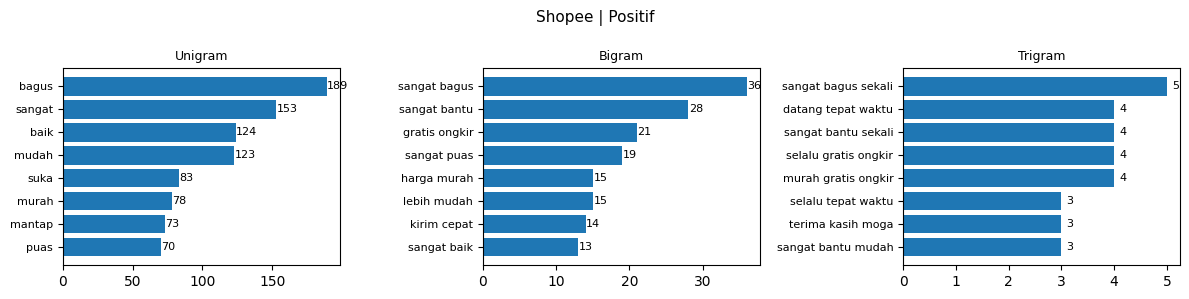

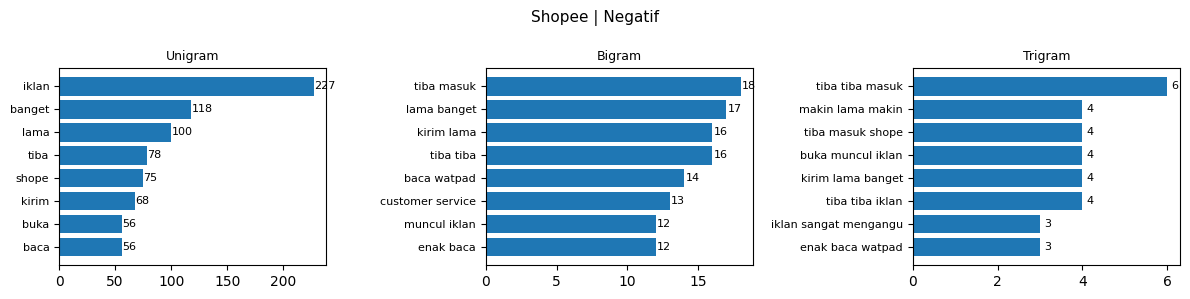

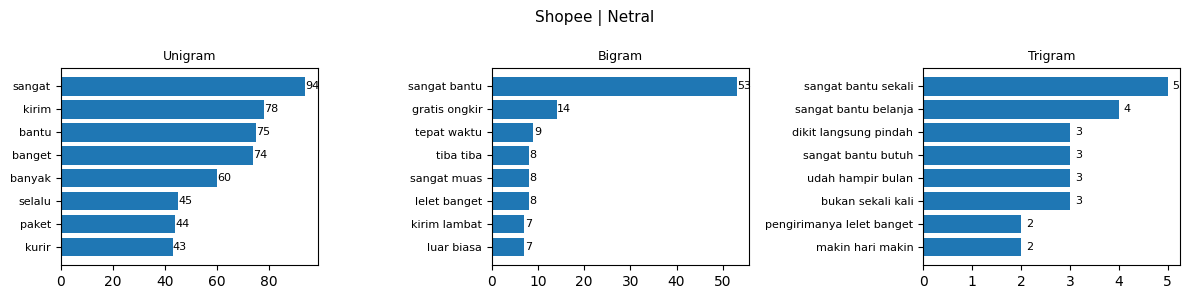

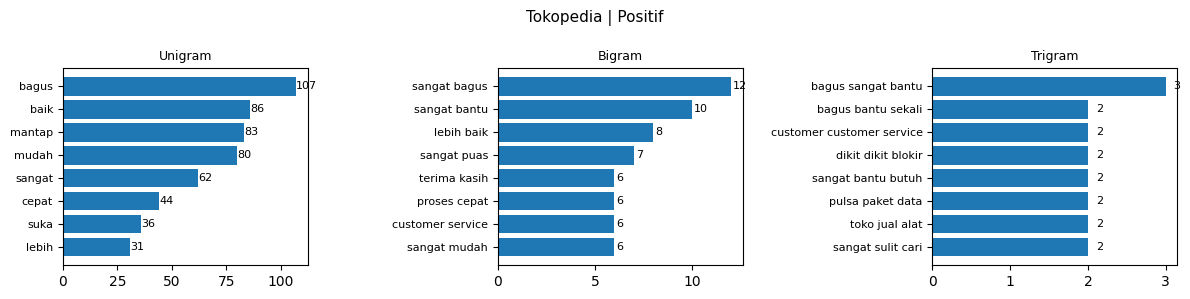

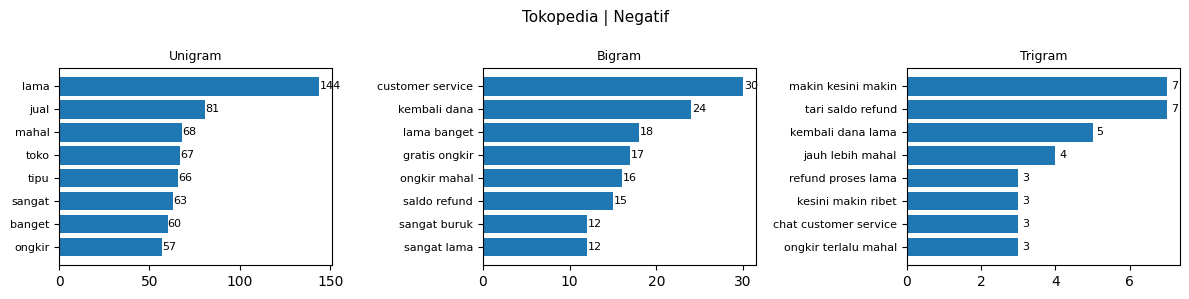

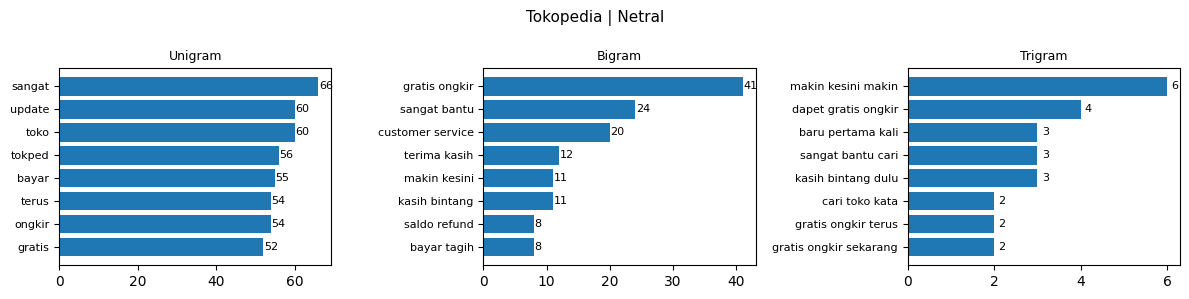

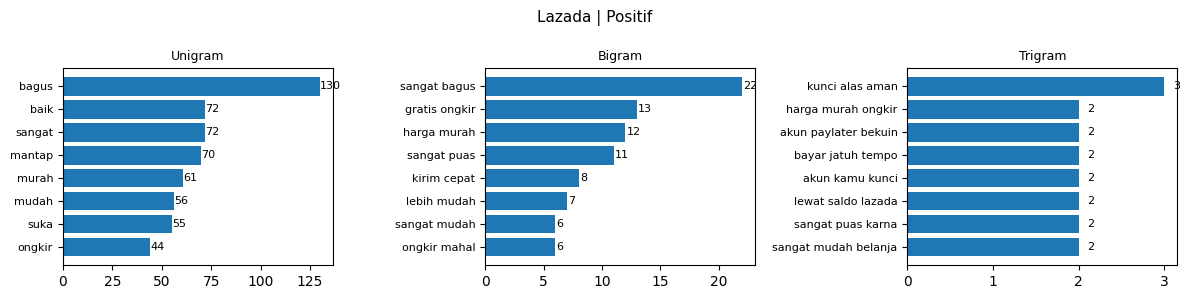

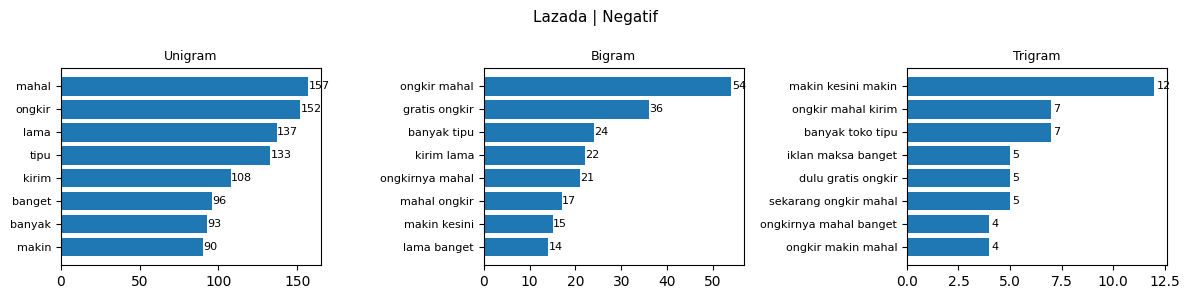

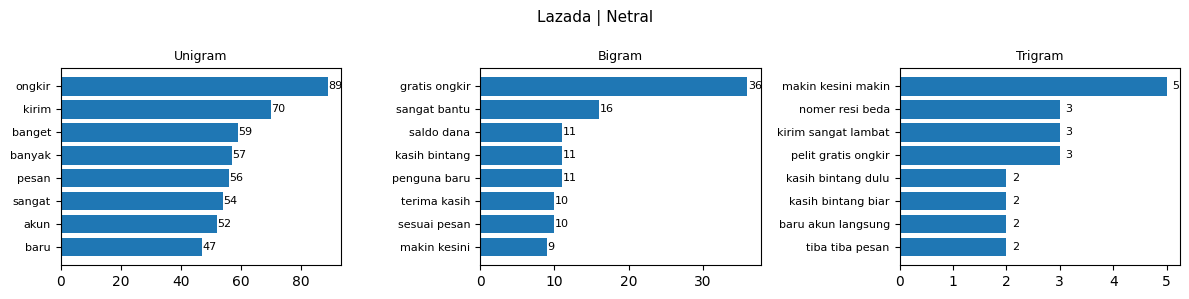

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

def plot_ngram_subplot(df, aplikasi, sentimen, top_n=8):
    ngram_configs = {
        'Unigram': (1,1),
        'Bigram':  (2,2),
        'Trigram': (3,3)
    }

    data = df[
        (df['aplikasi'] == aplikasi) &
        (df['sentimen'] == sentimen)
    ]

    if len(data) == 0:
        return

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    for ax, (nama, ngram_range) in zip(axes, ngram_configs.items()):
        try:
            vectorizer = CountVectorizer(
                ngram_range=ngram_range,
                min_df=1
            )

            X = vectorizer.fit_transform(data['clean_review'])

            ngram_df = pd.DataFrame(
                X.sum(axis=0),
                columns=vectorizer.get_feature_names_out()
            ).T

            ngram_df.columns = ['Frekuensi']
            ngram_df = ngram_df.sort_values(
                by='Frekuensi',
                ascending=False
            ).head(top_n)

            bars = ax.barh(
                ngram_df.index,
                ngram_df['Frekuensi']
            )

            ax.invert_yaxis()
            ax.set_title(nama, fontsize=9)
            ax.tick_params(axis='y', labelsize=8)

            for bar in bars:
                ax.text(
                    bar.get_width() + 0.1,
                    bar.get_y() + bar.get_height() / 2,
                    f'{int(bar.get_width())}',
                    va='center',
                    ha='left',
                    fontsize=8
                )

        except:
            ax.set_title(f'{nama}\n(Tidak ada data)', fontsize=8)
            ax.axis('off')

    fig.suptitle(f'{aplikasi} | {sentimen}', fontsize=11)
    plt.tight_layout()
    plt.show()

aplikasi_list = ['Shopee', 'Tokopedia', 'Lazada']
sentimen_list = ['Positif', 'Negatif', 'Netral']

for app in aplikasi_list:
    for sent in sentimen_list:
        plot_ngram_subplot(df, app, sent)


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/ReviewMentah.csv')

In [ ]:
data.head()

review  score aplikasi
0  shopee sangat bagus aku selalu pakek shopee      5   Shopee
1                      sangat bagus layanannya      5   Shopee
2                                 ⚠️👍🌟🌟🌟🌟🌟❗️🙏.      5   Shopee
3                                        buruk      3   Shopee
4                                     mantulll      5   Shopee

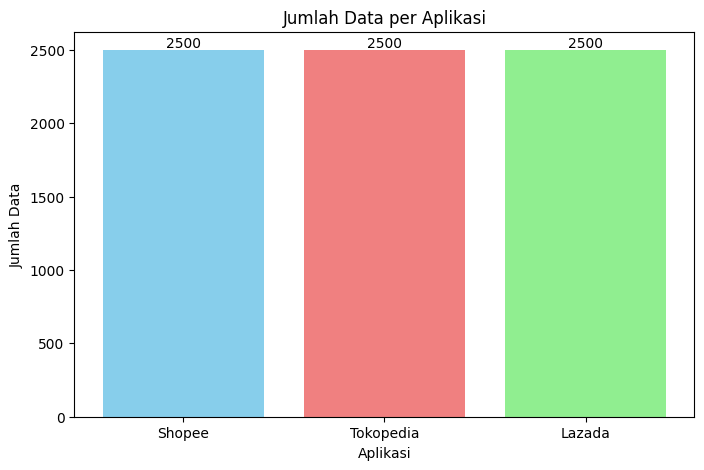

In [ ]:
import matplotlib.pyplot as plt

app_counts = data['aplikasi'].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(app_counts.index, app_counts.values, color=['skyblue', 'lightcoral', 'lightgreen'])

plt.title('Jumlah Data per Aplikasi')
plt.xlabel('Aplikasi')
plt.ylabel('Jumlah Data')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha='center',
        va='bottom'
    )

plt.show()